In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
smpDir = './00_prepTopoOptimData/'
prbDir = "topoOptim/"
dataNm = "feasibleSolutions.csv"
dataPath = smpDir + prbDir + dataNm

df = pd.read_csv(dataPath)

In [3]:
df.shape

(23792, 1122)

In [4]:
df.head()

,bit,bit.1,bit.2,bit.3,bit.4,bit.5,bit.6,bit.7,bit.8,bit.9,...,bit.1112,bit.1113,bit.1114,bit.1115,bit.1116,bit.1117,bit.1118,bit.1119,pressureRecoveryFactor,diffuserLength
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.264373,0.225
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.265390,0.225
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.263384,0.225
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.263055,0.225
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.206773,0.290


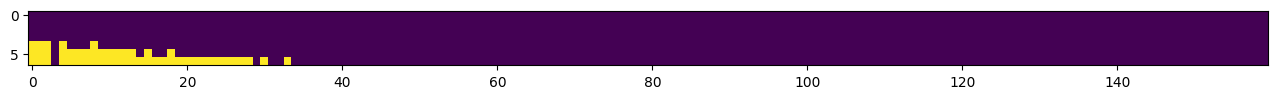

In [5]:
import random

# get a random row
example = df.iloc[random.randint(0, df.shape[0])]
example = example.drop(['pressureRecoveryFactor', 'diffuserLength'])
rows = 7
example = np.array(example).reshape(rows, -1)
# make plot wider
plt.figure(figsize=(16, 2))
plt.imshow(example)

In [6]:
df.duplicated().sum()

14211

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
data_shape = example.shape
data_shape

(7, 160)

In [9]:
data_shape = (data_shape[0], data_shape[1], 1)
data_shape

(7, 160, 1)

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, InputLayer
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError

In [11]:
# create a model
def get_model(data_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 5), activation='relu', padding='same', input_shape=data_shape))
    model.add(MaxPooling2D(pool_size=(1, 2), padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='linear'))
    return model


In [12]:
model = get_model(data_shape)
model.compile(loss='mse', optimizer=Adam(), metrics=[RootMeanSquaredError()])
display(model.summary())

# train model
early_stopping = EarlyStopping(monitor='loss', patience=3)
X, y = df.drop(['pressureRecoveryFactor', 'diffuserLength'], axis=1), df[['pressureRecoveryFactor', 'diffuserLength']]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

X_train = np.array(X_train).reshape(-1, data_shape[0], data_shape[1], data_shape[2])
X_val = np.array(X_val).reshape(-1, data_shape[0], data_shape[1], data_shape[2])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, callbacks=[early_stopping], validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 160, 32)        512       
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 80, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 80, 64)         30784     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 40, 64)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 17920)             0         
                                                                 
 dense (Dense)               (None, 128)               2

None

Epoch 1/10
105/105 [==============================] - 5s 42ms/step - loss: 0.0023 - root_mean_squared_error: 0.0478 - val_loss: 1.6287e-04 - val_root_mean_squared_error: 0.0128
Epoch 2/10
105/105 [==============================] - 4s 42ms/step - loss: 1.0475e-04 - root_mean_squared_error: 0.0102 - val_loss: 4.7018e-05 - val_root_mean_squared_error: 0.0069
Epoch 3/10
105/105 [==============================] - 5s 47ms/step - loss: 3.4765e-05 - root_mean_squared_error: 0.0059 - val_loss: 2.6084e-05 - val_root_mean_squared_error: 0.0051
Epoch 4/10
105/105 [==============================] - 5s 44ms/step - loss: 1.9218e-05 - root_mean_squared_error: 0.0044 - val_loss: 4.9655e-05 - val_root_mean_squared_error: 0.0070
Epoch 5/10
105/105 [==============================] - 4s 39ms/step - loss: 1.3317e-05 - root_mean_squared_error: 0.0036 - val_loss: 1.7758e-05 - val_root_mean_squared_error: 0.0042
Epoch 6/10
105/105 [==============================] - 4s 39ms/step - loss: 8.3289e-06 - root_mean_s

In [13]:
model.save('topOptimModel.keras')

In [14]:
loss = model.evaluate(X_val, y_val)
loss

90/90 [==============================] - 1s 7ms/step - loss: 8.1564e-06 - root_mean_squared_error: 0.0029


[8.156444891938008e-06, 0.002855949103832245]

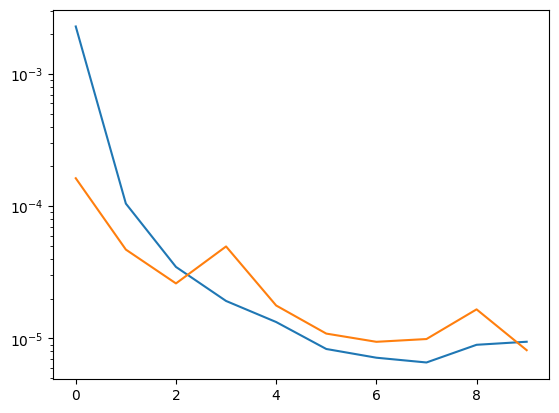

In [15]:
# plot loss
plt.yscale('log')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

90/90 [==============================] - 1s 7ms/step


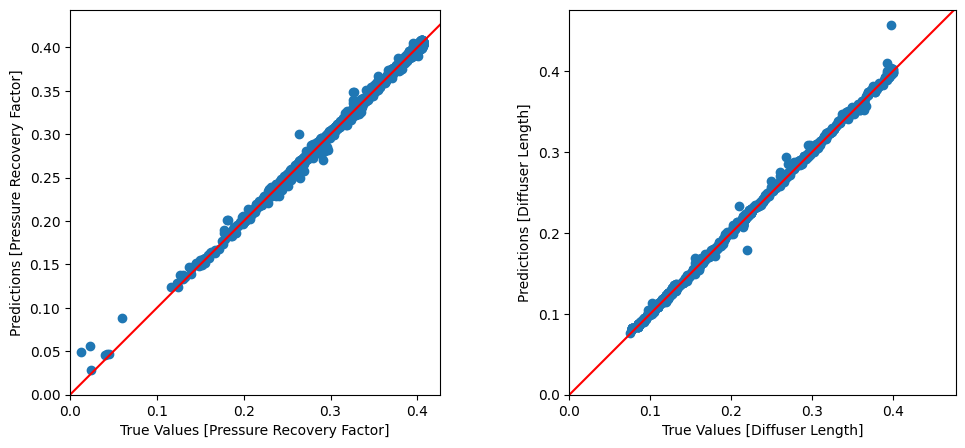

In [16]:
y_pred = model.predict(X_val)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(y_val['pressureRecoveryFactor'], y_pred[:, 0])
ax1.set_xlabel('True Values [Pressure Recovery Factor]')
ax1.set_ylabel('Predictions [Pressure Recovery Factor]')
ax1.axis('equal')
ax1.axis('square')
ax1.set_xlim([0, ax1.get_xlim()[1]])
ax1.set_ylim([0, ax1.get_ylim()[1]])
ax1.plot([-100, 100], [-100, 100], color='red')

ax2.scatter(y_val['diffuserLength'], y_pred[:, 1])
ax2.set_xlabel('True Values [Diffuser Length]')
ax2.set_ylabel('Predictions [Diffuser Length]')
ax2.axis('equal')
ax2.axis('square')
ax2.set_xlim([0, ax2.get_xlim()[1]])
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.plot([-100, 100], [-100, 100], color='red')